### rt
做 HCN/CO 的 ratio map

嘗試復現論文裡的操作：

1.5 arcsec 的網格和 3*3 arcsec 的 beam

檔案如下：
1. 
2. 
3. HCN-CO_ratio.fits


In [11]:
# import modular

from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from reproject import reproject_interp

from radio_beam import beam
from astropy.convolution import convolve_fft
from astropy import units as u

import numpy as np

In [113]:
# hand made function

# 存檔芝士
def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam):
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 新網格機！
'''
input a hdul&&像素步長 in arcsec
return new_shape, new_wcs, 和定義的 header 本人 
'''
def reGrid(reGrid_obj, pixelStep_target): 
    reGrid_obj_header = reGrid_obj[0].header
    ori_n1, ori_n2 = reGrid_obj[0].data.squeeze().shape # (y, x)
    print('Get the input HDUL successfully!') ##
    new_n2 = int(ori_n2*abs(reGrid_obj_header['CDELT1']) / (pixelStep_target/3600)) # 要純量相除！
    new_n1 = int(ori_n1*abs(reGrid_obj_header['CDELT2']) / (pixelStep_target/3600))
    new_header = fits.Header()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = new_n2
    new_header['NAXIS2'] = new_n1
    new_header['CRPIX1'] = new_n2 * 0.5 + 1
    new_header['CRPIX2'] = new_n1 * 0.5 + 1
    new_header['CRVAL1'] = 213.2915 # 暴力抓蟲
    new_header['CRVAL2'] = -65.339 # 暴力抓蟲
    new_header['CDELT1'] = pixelStep_target / -3600
    new_header['CDELT2'] = pixelStep_target / 3600
    new_header['CTYPE1'] = 'RA---SIN'
    new_header['CTYPE2'] = 'DEC--SIN'
    new_header['CUNIT1'] = 'deg'
    new_header['CUNIT2'] = 'deg'
    ## 不確定但先寫著，沒 beam 很奇怪耶
    new_header['BMAJ'] = reGrid_obj_header['BMAJ']
    new_header['BMIN'] = reGrid_obj_header['BMIN']
    new_header['BPA'] = reGrid_obj_header['BPA']
    print('Giving reprojecting material...')
    print((new_n2, new_n1))
    return (new_n2, new_n1), WCS(new_header), new_header

In [70]:
# import data (moment0.fit of CO&&HCN)

CO_hdul = fits.open("/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/oldData/CO(1-0)_mom0_oldData.fits")
HCN_hdul = fits.open("/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/oldData/HCN(1-0)_mom0_oldData.fits")

CO_header, HCN_header = CO_hdul[0].header, HCN_hdul[0].header
CO_ima, HCN_ima = CO_hdul[0].data.squeeze(), HCN_hdul[0].data.squeeze()

original_wcs = WCS(CO_header)
print("Original WCS is valid:", original_wcs.is_celestial)

Original WCS is valid: False


Get the input HDUL successfully!
Giving reprojecting material...
(106, 106)
Get the input HDUL successfully!
Giving reprojecting material...
(75, 75)


/Users/aqing/miniconda3_x86/envs/astro_py310/lib/python3.10/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -67.754929 from OBSGEO-[XYZ].
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.
  warnings.warn(


'\nplt.figure(3)\nplt.subplot(projection=HCN_wcs)\nplt.imshow(HCN_ima)\n'

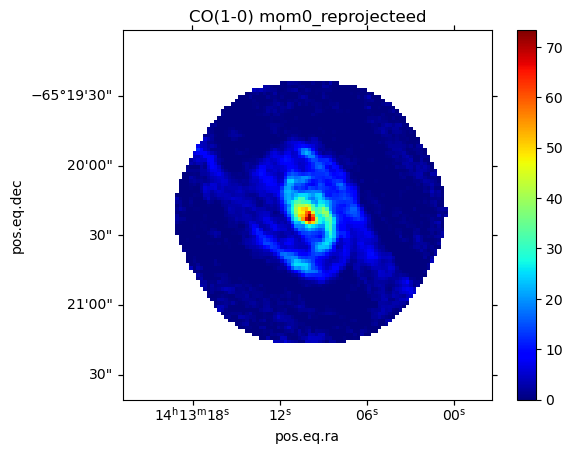

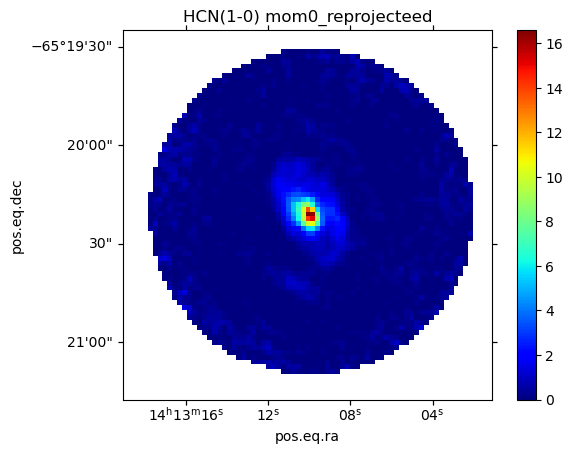

In [114]:
# reprojection
CO_wcs, HCN_wcs = WCS(CO_header, naxis=2), WCS(HCN_header, naxis=2)
#print(CO_wcs, HCN_wcs)
pixelStep = 1.5 # arcsec
CO_new_shape, CO_new_wcs, CO_new_header = reGrid(CO_hdul, pixelStep)
CO_ima_reproj, _ = reproject_interp((CO_ima, CO_wcs), CO_new_wcs, shape_out=CO_new_shape)
#print(CO_new_header)
HCN_new_shape, HCN_new_wcs, HCN_new_header = reGrid(HCN_hdul, pixelStep)
HCN_ima_reproj, _ = reproject_interp((HCN_ima, HCN_wcs), HCN_new_wcs, shape_out=HCN_new_shape)

plt.figure(1) 
plt.subplot(projection=CO_new_wcs)
plt.imshow(CO_ima_reproj, cmap='jet', vmin=0)
plt.colorbar()
plt.title("CO(1-0) mom0_reprojecteed")
plt.figure(2)
plt.subplot(projection=HCN_new_wcs)
plt.imshow(HCN_ima_reproj, cmap='jet', vmin=0)
plt.colorbar()
plt.title("HCN(1-0) mom0_reprojecteed")
'''
plt.figure(3)
plt.subplot(projection=HCN_wcs)
plt.imshow(HCN_ima)
'''
#plt.show()